# Parallel processing

It is common to want to study the magnetic response of a device as a function one or more properties of the device, or as a function of one of the applied boundary conditions. The `superscreen.solve_many()` function provides a convenient interface for performing "sweeps" of this type, where the properies that can be swept include:

- The applied field $H_{z,\,\mathrm{applied}}$
- Any circulating currents associated with trapped flux
- The number and position of vortices trapped in the `Device`
- The effective penetration depth $\Lambda(x, y)$ (`Lambda`) or $\lambda(x, y)$ (`london_lambda`) of each `Layer` in the `Device`
- The vertical position $z_0$ of each `Layer` in the `Device`

The geometry of the `Device` parallel to the $x-y$ plane cannot be swept in `solve_many()` because changing the geometry requires re-generating the mesh.

In [1]:
%config InlineBackend.figure_formats = {"retina", "png"}
%matplotlib inline

import os
import time
import logging

os.environ["OPENBLAS_NUM_THREADS"] = "1"

logging.basicConfig(level=logging.INFO)

import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams["font.size"] = 14
from IPython.display import clear_output

import superscreen as sc
from superscreen.geometry import circle

## Introduction

The idea behind `superscreen.solve_many()` is to create a set of **models** based on a single `Device` and solve them all with a single command. A single **model** consists of the following:

- A `superscreen.Parameter` that calculates the applied magnetic field (if any).
- A `dict` of `{hole_name: circulating_current}` specifying the circulating currents in the `Device` (if any).
- A `list` of `superscreen.Vortex` objects representing vortices trapped in the `Device`.

Additionally, for each **model** the penetration depth and/or $z$-position of each `layer` in the `Device` can be modified by a `layer_updater` function that takes some `update_kwargs` such that

```python
new_layer = layer_updater(old_layer, **update_kwargs)
```

In pseudocode, `superscreen.solve_many()` does the following:

```python
# Simplified pseudocode for superscreen.solve_many().
# Given a Device, a layer_updater function, and a list of "models":
model_solutions = []
for model in models:
    applied_field, circulating_currents, vortices, update_kwargs = model
    device.layers_list = [layer_updater(layer, **update_kwargs) for layer in device.layers_list]
    solutions = superscreen.solve(
        device,
        applied_field=applied_field,
        circulating_currents=circulating_currents,
        vortices=vortices,
        ...,
    )
    model_solutions.append(solutions)
# Save and/or return model_solutions.
```

There are a few reasons one would want to use `superscreen.solve_many()` instead of simply writing out a `for` loop:

1. `solve_many()` takes care of generating the list of **models** to solve.
2. `solve_many()` takes care of saving results in a convenient way.
3. The `for` loop in the pseudocode above can be parallelized to run across multiple CPUs or even multiple nodes in a computing cluster.

### Parallel methods

There are three different "parallel methods" that can be specified when calling `superscreen.solve_many()`:

1. `"serial"` or `None`: All models are solved sequentially in a single Python process (a simple `for` loop as sketched above).
2. `"multiprocessing"` or `"mp"`: Models are solved in parallel using at most `ncpu` processes, where `ncpu` is the number of CPU cores available. This option uses the [multiprocessing](https://docs.python.org/3/library/multiprocessing.html) package from the Python standard library.
3. `"ray"`: Models are solved in parallel on multiple CPUs using the third-party distributed computing package, [ray](https://docs.ray.io/en/latest/index.html).

Both the `"multiprocessing"` and `"ray"` options are implemented such that a `Device's` "big" arrays, i.e. the mesh, Laplace operator, and kernel matrix, are placed in shared memory rather than copied to each worker process. The `"multiprocessing"` option is limited to work on a single machine (i.e. a laptop, workstation, or a single node in a compute cluster). The `"ray"` option can in principle also be used across multiple nodes in a cluster (see the [ray documentation](https://docs.ray.io/en/latest/cluster/index.html)).

### Disclaimer

It is important to note that the relative performance of the three different "parallel methods" will in general depend on the specific models your are solving, and on the setup of your machine (how many CPU cores, what other programs are running, etc.). With both `multiprocessing` and `ray`, there is some overhead associated with placing arrays in shared memory and spinning up and managing new processes. This means that if each call to `solve()` (see the pseudocode above) takes only a few seconds, you are unlikely to see a big performance improvement relative to serial execution. In the limit that each call to `solve()` takes a long time relative to this overhead, you can in principle get a speedup of order `ncpu`, where `ncpu` is the number of CPUs avilable. We recommend comparing the three parallel methods in your own application before deciding which to use.

In [2]:
sc.version_table()

Software,Version
SuperScreen,0.4.0
Numpy,1.20.3
SciPy,1.6.3
matplotlib,3.4.3
ray,1.4.1
IPython,7.24.1
Python,"3.9.5 (default, May 18 2021, 12:31:01) [Clang 10.0.0 ]"
OS,posix [darwin]
Number of CPUs,"Physical: 2, Logical: 4"
BLAS Info,OPENBLAS


## Example

Here we will demonstrate the use of `superscreen.solve_many()` by modeling the mutual inductance between two concentric rings as a function of both their penetration depth $\Lambda$ and the vertical distance $\Delta z$ between them.

### Setup

Define a function to create out `Device` with two concentric rings.

In [3]:
def two_rings(inner_radius=3, outer_radius=5, length_units="um"):
    """Returns a Device representing two concentric rings."""
    layers = [
        sc.Layer("layer0", Lambda=0, z0=0),
        sc.Layer("layer1", Lambda=0, z0=1),
    ]
    films = [
        sc.Polygon("big_ring", layer="layer0", points=circle(1.5 * outer_radius)),
        sc.Polygon("little_ring", layer="layer1", points=circle(outer_radius)),
    ]
    holes = [
        sc.Polygon("big_hole", layer="layer0", points=circle(1.5 * inner_radius)),
        sc.Polygon("little_hole", layer="layer1", points=circle(inner_radius)),
    ]
    abstract_regions = [
        sc.Polygon("bounding_box", layer="layer0", points=circle(2 * outer_radius)),
    ]
    return sc.Device(
        "two_rings",
        layers=layers,
        films=films,
        holes=holes,
        abstract_regions=abstract_regions,
        length_units=length_units,
    )

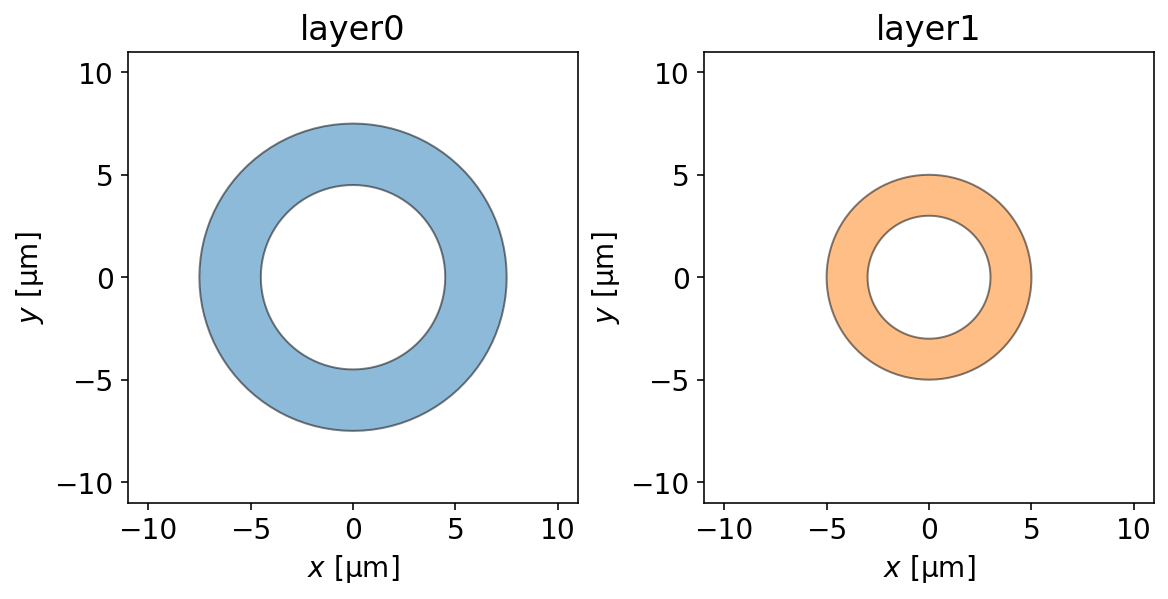

In [4]:
device = two_rings()
_ = device.draw(exclude="bounding_box", subplots=True)

In [5]:
device.make_mesh(min_points=3000)

INFO:superscreen.device.device:Generating mesh...
INFO:superscreen.device.device:Finished generating mesh with 3174 points and 6201 triangles.
INFO:superscreen.device.device:Calculating weight matrix.
INFO:superscreen.device.device:Calculating Laplace operator.
INFO:superscreen.device.device:Calculating kernel matrix.


Recall that to model the mutual inductance $M$ between two holes, we specify a current $I_\mathrm{circ}$ to circulate around one of the holes, and calculate the fluxoid $\Phi^f_S$ induced in the other hole. The mutual inductance is then $M=\Phi^f_S / I_\mathrm{circ}$.

In [6]:
I_circ = device.ureg("1 mA")
circulating_currents = {"big_hole": str(I_circ)}

In [7]:
NUM_CPUS = 2

### Sweep $\Lambda$

In [8]:
def update_Lambda(layer, **Lambdas):
    """Updates a layer based on a dict Lambdas = {layer_name: layer_Lambda}."""
    if layer.name in Lambdas:
        layer.Lambda = Lambdas[layer.name]
    return layer


def sweep_Lambda(Lambdas, iterations=6, parallel_method=None):
    """Sweep Lambda using superscreen.solve_many()."""

    layer_update_kwargs = [
        {layer.name: Lambda for layer in device.layers.values()} for Lambda in Lambdas
    ]

    start = time.perf_counter()

    solutions, paths = sc.solve_many(
        device,
        circulating_currents=circulating_currents,
        layer_updater=update_Lambda,
        layer_update_kwargs=layer_update_kwargs,
        parallel_method=parallel_method,
        num_cpus=NUM_CPUS,
        iterations=iterations,
        return_solutions=True,
        keep_only_final_solution=True,
    )

    end = time.perf_counter()
    elapsed_seconds = end - start
    seconds_per_model = elapsed_seconds / len(Lambdas)
    clear_output(wait=True)
    print(
        f"parallel_method = {parallel_method}, "
        f"elapsed_seconds = {elapsed_seconds:.3f}, "
        f"seconds_per_model = {seconds_per_model:.3f}"
    )
    return solutions

In [9]:
Lambdas = np.linspace(0, 0.95, 20)

In [10]:
solutions = sweep_Lambda(Lambdas, parallel_method=None)

parallel_method = None, elapsed_seconds = 36.345, seconds_per_model = 1.817


In [11]:
solutions_ray = sweep_Lambda(Lambdas, parallel_method="ray")

parallel_method = ray, elapsed_seconds = 30.888, seconds_per_model = 1.544


In [12]:
solutions_mp = sweep_Lambda(Lambdas, parallel_method="multiprocessing")

parallel_method = multiprocessing, elapsed_seconds = 26.741, seconds_per_model = 1.337


Calculcate and plot the mutual inductance $M$ for each `Solution`:

In [13]:
mutuals = []
for i, solution in enumerate(solutions):
    print(i, end=" ")
    fluxoid = sum(solution.hole_fluxoid("little_hole"))
    mutuals.append((fluxoid / I_circ).to("pH").magnitude)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 

Text(0.5, 1.0, '$\\Delta z$ = 1.0 $\\mu$m')

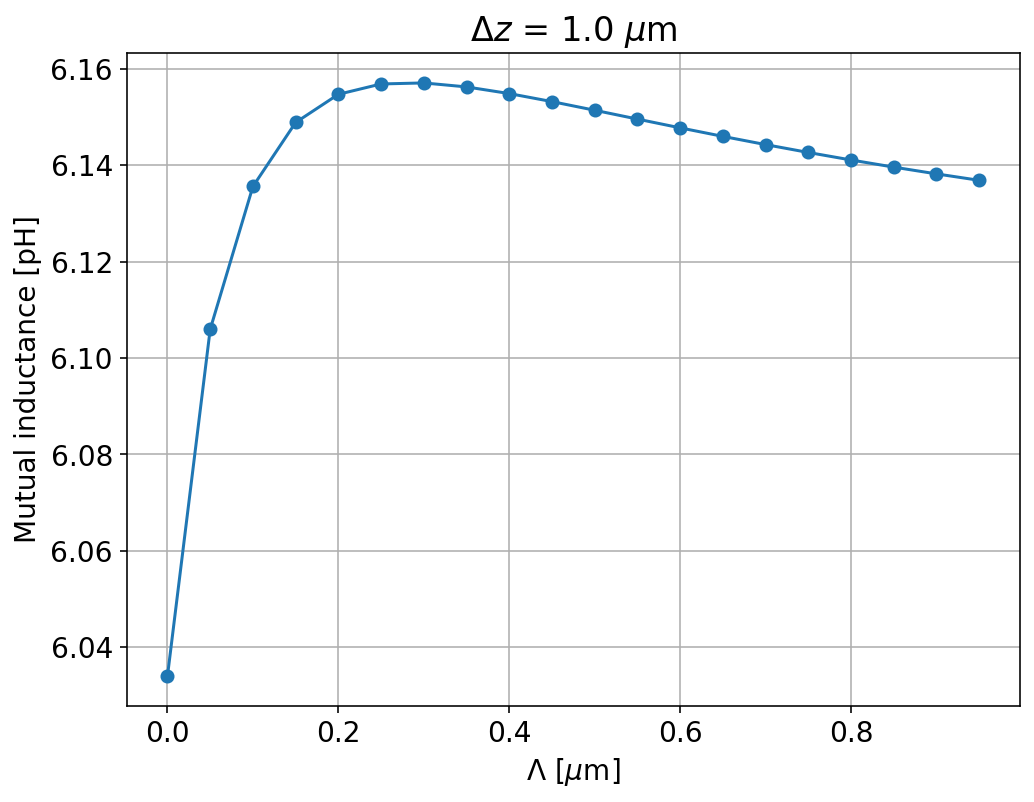

In [14]:
fig, ax = plt.subplots()
ax.plot(Lambdas, mutuals, "o-")
ax.grid(True)
ax.set_xlabel("$\\Lambda$ [$\\mu$m]")
ax.set_ylabel("Mutual inductance [pH]")
DeltaZ = device.layers["layer1"].z0 - device.layers["layer0"].z0
ax.set_title(f"$\\Delta z$ = {DeltaZ:.1f} $\\mu$m")

### Sweep $\Delta z$

In [15]:
def update_height(layer, **heights):
    if layer.name in heights:
        layer.z0 = heights[layer.name]
    return layer


def sweep_height(heights, iterations=6, parallel_method=None):
    """Sweep \Delta z using superscreen.solve_many()."""

    layer_update_kwargs = [dict(layer0=0, layer1=z0) for z0 in heights]

    start = time.perf_counter()

    solutions, paths = sc.solve_many(
        device,
        circulating_currents=circulating_currents,
        layer_updater=update_height,
        layer_update_kwargs=layer_update_kwargs,
        parallel_method=parallel_method,
        num_cpus=NUM_CPUS,
        iterations=iterations,
        return_solutions=True,
        keep_only_final_solution=True,
    )

    end = time.perf_counter()
    elapsed_seconds = end - start
    seconds_per_model = elapsed_seconds / len(heights)

    clear_output(wait=True)
    print(
        f"parallel_method = {parallel_method}, "
        f"elapsed_seconds = {elapsed_seconds:.3f}, "
        f"seconds_per_model = {seconds_per_model:.3f}"
    )
    return solutions

In [16]:
z0s = np.linspace(0.5, 5.5, 20)

# Set Lambda = 0.5 microns for both layers
Lambda = 0.5
for layer in device.layers.values():
    layer.Lambda = Lambda

In [17]:
solutions = sweep_height(z0s, parallel_method=None)

parallel_method = None, elapsed_seconds = 32.093, seconds_per_model = 1.605


In [18]:
solutions = sweep_height(z0s, parallel_method="ray")

parallel_method = ray, elapsed_seconds = 30.231, seconds_per_model = 1.512


In [19]:
solutions = sweep_height(z0s, parallel_method="multiprocessing")

parallel_method = multiprocessing, elapsed_seconds = 25.105, seconds_per_model = 1.255


Calculcate and plot the mutual inductance $M$ for each `Solution`:

In [20]:
mutuals = []
for i, solution in enumerate(solutions):
    print(i, end=" ")
    fluxoid = sum(solution.hole_fluxoid("little_hole"))
    mutuals.append((fluxoid / I_circ).to("pH").magnitude)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 

Text(0.5, 1.0, '$\\Lambda$ = 0.5 $\\mu$m')

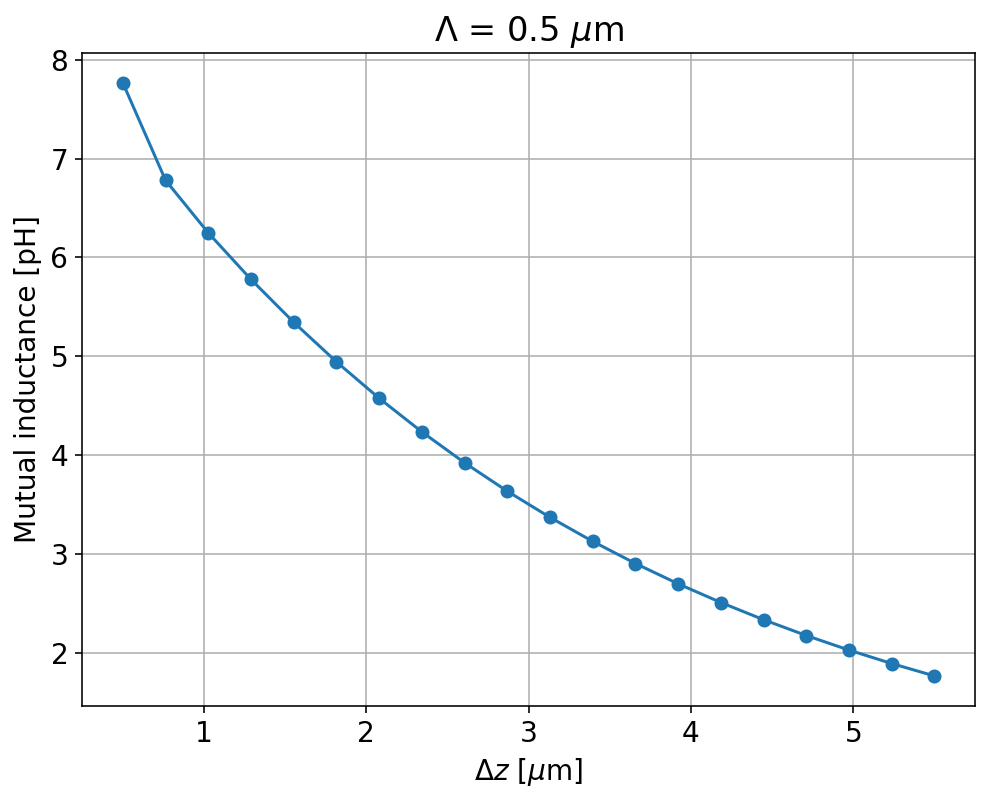

In [21]:
fig, ax = plt.subplots()
ax.plot(z0s, mutuals, "o-")
ax.grid(True)
ax.set_xlabel("$\\Delta z$ [$\\mu$m]")
ax.set_ylabel("Mutual inductance [pH]")
ax.set_title(f"$\\Lambda$ = {Lambda:.1f} $\\mu$m")